In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNetV2
from keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import os
import numpy as np

2025-07-18 15:28:51.768100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752852532.154852      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752852532.261809      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
conv_base = ResNet50(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

I0000 00:00:1752850710.267955      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752850710.268678      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

I0000 00:00:1752852552.447879      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752852552.448936      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

In [26]:
# Define data augmentation
data_augmentation = keras.Sequential([
    # layers.RandomZoom(0.2),
    # layers.RandomTranslation(0.2, 0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.3),
])


In [27]:
# Load dataset from input/fold
dataset_path = "/kaggle/input/refined-model-data/dataset_1/preprocessed_original_images/"
img_height = 224
img_width = 224
batch_size = 20

dataset = keras.utils.image_dataset_from_directory(
    directory=dataset_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 847 files belonging to 6 classes.


In [28]:
# Split dataset into train (80%) and test (20%)
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Further split train_dataset into train (80%) and validation (20%)
val_size = int(0.2 * train_size)
train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)

In [30]:
# Function to apply augmentation and normalization to training data
def process_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = data_augmentation(image)            # Apply augmentation
    return image, label

# Function to normalize validation and test data
def process_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

In [31]:
# Apply processing functions
train_dataset = train_dataset.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [32]:
# # Load VGG16 base model
# conv_base = keras.applications.VGG16(
#     weights='imagenet', 
#     include_top=False, 
#     input_shape=(224, 224, 3))

In [33]:
# # Unfreeze top 30 layers
for layer in conv_base.layers[-40:]:
    layer.trainable = True

In [34]:
# Define model-building function for Keras Tuner
def build_model(hp):
    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = conv_base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    
    # model = keras.Sequential()
    # model.add(conv_base)
    # model.add(layers.GlobalAveragePooling2D())
    # model.add(layers.Dense(
    #     units=hp.Int('units', min_value=128, max_value=512, step=128),
    #     activation='relu'
    # ))
    # model.add(layers.Dropout(0.3))
    # model.add(layers.Dense(6, activation='softmax'))  # 4 classes
    # model.compile(
    #     optimizer=keras.optimizers.Adam(
    #         hp.Float('learning_rate', 1e-5, 1e-1, sampling='log')
    #     ),
    #     loss='sparse_categorical_crossentropy',
    #     metrics=['accuracy']
    # )
    return model


In [35]:
# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_dir_resnet_data_1',
    project_name='resnet_classification_data_1'
)
# Search for best hyperparameters
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    # class_weight=class_weights
)

Reloading Tuner from tuner_dir_resnet_data_1/resnet_classification_data_1/tuner0.json


In [36]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Create output directory
output_dir = 'resnet/'
os.makedirs(output_dir, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


KeyError: 'units does not exist.'

In [37]:
# Save the best model and weights
best_model.save(os.path.join(output_dir, 'best_model.keras'))
best_model.save_weights(os.path.join(output_dir, 'best_model_weights.weights.h5'))

# Define callbacks for further training
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(output_dir, 'best_finetuned_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)


NameError: name 'output_dir' is not defined

In [38]:
# Further train the best model
history = best_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    # class_weight=class_weights,
    # callbacks=[checkpoint]
)



Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - accuracy: 0.4923 - loss: 1.3662 - val_accuracy: 0.2667 - val_loss: 3.0907
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.5162 - loss: 1.2542 - val_accuracy: 0.4583 - val_loss: 1.3726
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.4457 - loss: 1.3161 - val_accuracy: 0.3917 - val_loss: 1.4409
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.4972 - loss: 1.2664 - val_accuracy: 0.4250 - val_loss: 1.5298
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.4745 - loss: 1.2413 - val_accuracy: 0.4500 - val_loss: 1.5414
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.4915 - loss: 1.2147 - val_accuracy: 0.4917 - val_loss: 1.3933
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.5208 - loss: 1.2287 - val_accuracy: 0.4083 - val_loss: 1.6381
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.5153 - loss: 1.2205 - val_acc

In [39]:
# Evaluate the model on test dataset
loss, accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.4713 - loss: 1.7799
Test Loss: 1.7936
Test Accuracy: 0.4551


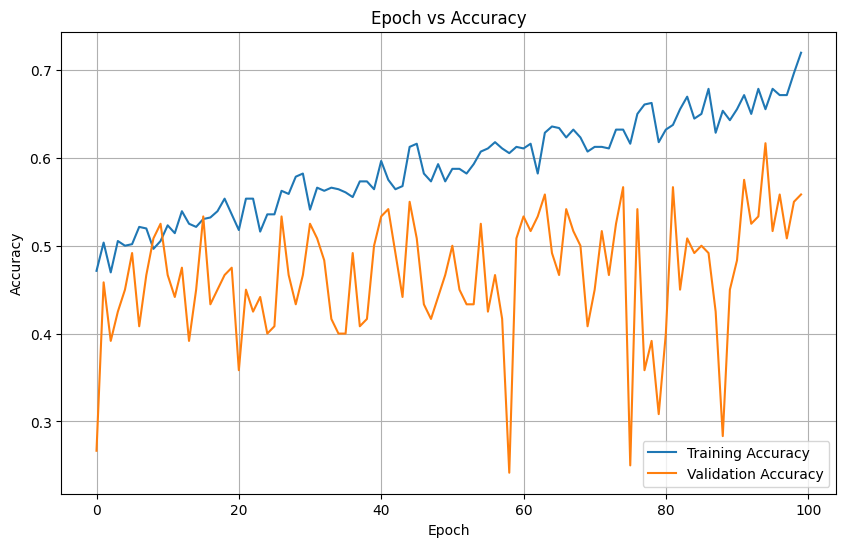

In [40]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
# plt.savefig('/kaggle/working/resnet/accuracy_plot.png')
plt.show()

In [ ]:
best_model.summary()

In [ ]:
dataset.class_names

In [41]:
# --- Evaluation Metrics ---
# Collect true labels and predictions from the test dataset
from sklearn.metrics import classification_report

y_true = []
y_pred = []
y_pred_proba = []
class_names=dataset.class_names

for images, labels in test_dataset.unbatch():
    y_true.append(labels.numpy())
    predictions = best_model.predict(images[None, ...], verbose=0)
    y_pred.append(np.argmax(predictions, axis=1)[0])
    y_pred_proba.append(predictions[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

  chickenpox       0.27      0.41      0.33        29
      cowpox       0.13      0.33      0.19         6
     healthy       1.00      0.11      0.20         9
     measles       0.75      0.18      0.29        17
   monkeypox       1.00      0.03      0.05        36
    smallpox       0.56      0.81      0.66        70

    accuracy                           0.46       167
   macro avg       0.62      0.31      0.29       167
weighted avg       0.63      0.46      0.39       167



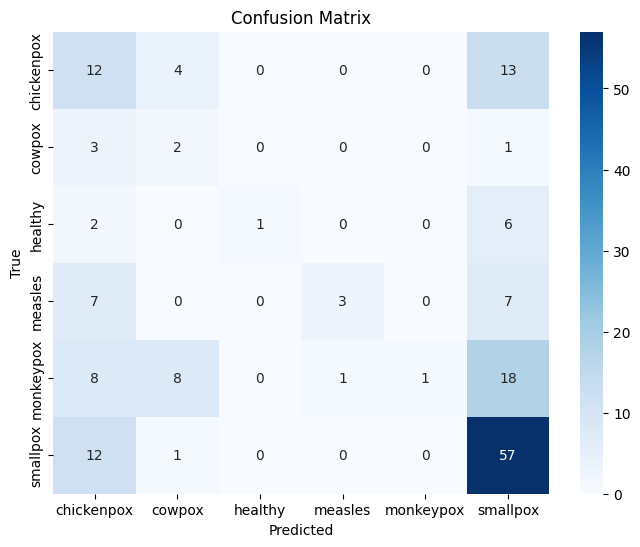

In [42]:
# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

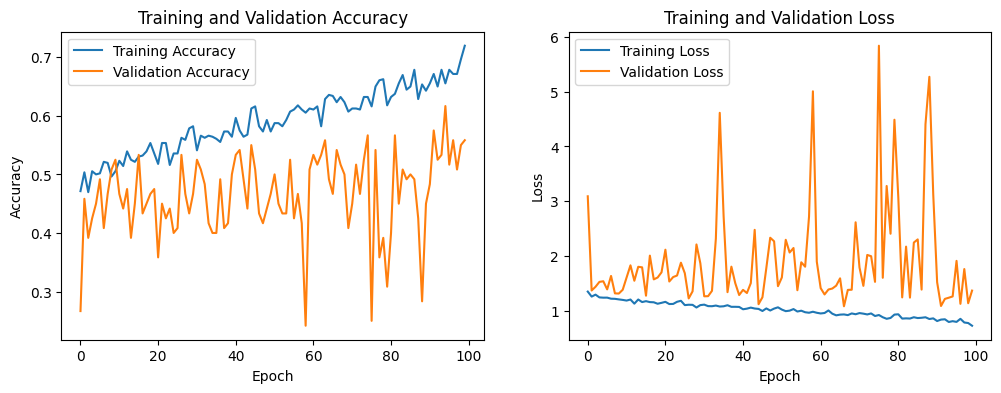

In [43]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

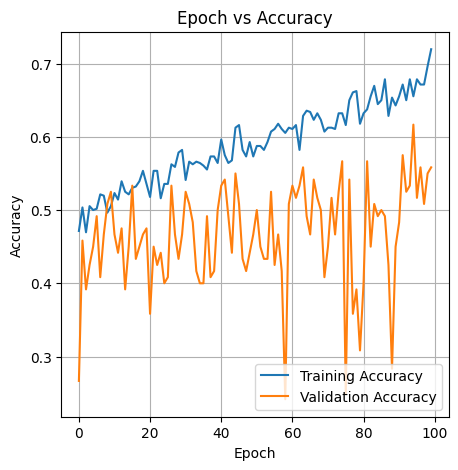

In [45]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
# plt.savefig('/kaggle/working/resnet/accuracy_plot.png')
plt.show()